In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import torch
import argparse
import os
import random
import time
from multiprocessing import Pool

import numpy as np
from numpy import linalg as LA

from scipy.signal import find_peaks
from tqdm.contrib.concurrent import process_map                

In [3]:
def align(ref, can, ref_sign, can_sign):
    """
    Function for aligning two signals.

    Args:
        ref (numpy_arr): normalized reference signal
        can (numpy_arr): normalized candidate signal
        ref_sign (numpy_arr): reference signal
        can_sign (numpy_arr): candidate signal

    Returns:
        _type_: 2 numpy arrays
    """
    corr = np.correlate(ref, can, mode="same")
    delay = np.argmax(corr) - (len(ref) // 2)
    if delay == 0:
        return ref_sign, can_sign
    elif delay > 0:
        return ref_sign[delay:], can_sign[:-delay]
    else:
        return ref_sign[:delay], can_sign[abs(delay) :]


def find_collisions(pair):
    """
    For each record index, It finds signals which are above the cross-correlation threshold and systolic blood pressure threshold by comparing with each signal in other record index.

    Args:
        i (int): Record index
    """
    i, j = pair
    ans = []
    os.makedirs(f"{args.dst_path}/{i}", exist_ok=True)
    for index_1 in range(len(ppg[i])):
        sample_abp_arr = abp[i][index_1]
        sample_sbp_val = sbp[i][index_1]
        for index_2 in range(len(ppg[j])):
            corr = np.correlate(
                normalized_ppg[i][index_1], normalized_ppg[j][index_2]
            ) / max(
                len(normalized_ppg[i][index_1]), len(normalized_ppg[j][index_2])
            )  # Obtain the correlation value between the normalized signals
            if corr >= args.cross_corr_threshold:
                ppg_1, ppg_2 = align(
                    normalized_ppg[i][index_1],
                    normalized_ppg[j][index_2],
                    ppg[i][index_1],
                    ppg[j][index_2],
                )
                dist = np.linalg.norm(ppg_1 - ppg_2) / max(
                    np.max(abs(ppg_1)), np.max(abs(ppg_2))
                )  # Calculate the Euclidean Distance
                if dist < args.euclid_threshold and (
                    abs(np.mean(sample_abp_arr) - np.mean(abp[j][index_2]))
                    > args.sbp_threshold
                    or abs(sample_sbp_val - sbp[j][index_2]) > args.sbp_threshold
                ):
                    ans.append([index_1, index_2, corr, dist])
    if ans:
        np.save(
            f"{args.dst_path}/{i}/{j}.npy", np.asarray(ans, dtype=object)
        )  # Stores all the collisions with indices and values


def check(i):
    """
    Helper function to create all the possible pairs and then multiprocess
    """
    pair_list = [(i, j) for j in range(len(normalized_ppg)) if j != i]
    process_map(find_collisions, pair_list, max_workers=args.max_workers)
    return

In [5]:
test_2 = np.load("F:\\minowa\\BloodPressureEstimation\\data\\processed\\BP_npy\\PulseDB\\test_2.npy")[:,1]
test_sbp_2 = np.load("F:\\minowa\\BloodPressureEstimation\\data\\processed\\BP_npy\\PulseDB\\test_sbp_2.npy")
test_dbp = np.load("F:\\minowa\\BloodPressureEstimation\\data\\processed\\BP_npy\\PulseDB\\test_dbp.npy")
test_4 = np.load("F:\\minowa\\BloodPressureEstimation\\data\\processed\\BP_npy\\PulseDB\\test_4.npy").squeeze()
test_sbp = np.load("F:\\minowa\\BloodPressureEstimation\\data\\processed\\BP_npy\\PulseDB\\test_sbp.npy")
test_subjects_4 = np.load("F:\\minowa\\BloodPressureEstimation\\data\\processed\\BP_npy\\PulseDB\\test_subjects.npy")
test_subjects_2 = np.load("F:\\minowa\\BloodPressureEstimation\\data\\processed\\BP_npy\\PulseDB\\test_subjects_2.npy")
test_2.shape,test_sbp_2.shape,test_dbp.shape,test_4.shape,test_sbp.shape

((38110, 1250), (38110,), (111600,), (111600, 1250), (111600,))

In [24]:
test_sbp

array([115.12022062, 190.86836291, 120.08544825, ...,  85.05153758,
       121.28642346,  91.24269023])

In [11]:
test_raw = np.load("F:\\minowa\\BloodPressureEstimation\\data\\processed\\BP_npy\\PulseDB\\test_raw.npy")
test_raw.shape

(111600, 2, 1250)

In [8]:
np.unique(test_subjects_4,return_counts=True),111600/400

((array([   53,    68,   103,   184,   195,   205,   216,   266,   303,
           317,   328,   340,   415,   558,   582,   630,   665,   668,
           675,   687,   750,   804,   906,  1046,  1052,  1091,  1092,
          1123,  1204,  1295,  1332,  1492,  1506,  1513,  1523,  1543,
          1549,  1625,  1710,  1764,  1885,  1949,  1958,  2042,  2044,
          2051,  2097,  2155,  2175,  2240,  2303,  2369,  2457,  2466,
          2483,  2490,  2491,  2496,  2498,  2537,  2602,  2713,  2815,
          2922,  2957,  2979,  2998,  3021,  3071,  3155,  3183,  3224,
          3246,  3320,  3348,  3361,  3400,  3424,  3430,  3477,  3526,
          3551,  3612,  3684,  3716,  3739,  3754,  3771,  3778,  3810,
          3831,  3834,  3893,  3977,  3990,  4060,  4112,  4135,  4199,
          4200,  4339,  4353,  4381,  4384,  4426,  4434,  4463,  4524,
          4531,  4536,  4569,  4593,  4623,  4729,  4772,  4795,  4833,
          4858,  4872,  4970,  5035,  5049,  5069,  5081,  5096,

In [49]:
target = test_4[test_subjects_4==53].reshape(-1,1,1250)

target_sbp = test_sbp[test_subjects_4==53]
target.shape,target_sbp.shape

((400, 1, 1250), (400,))

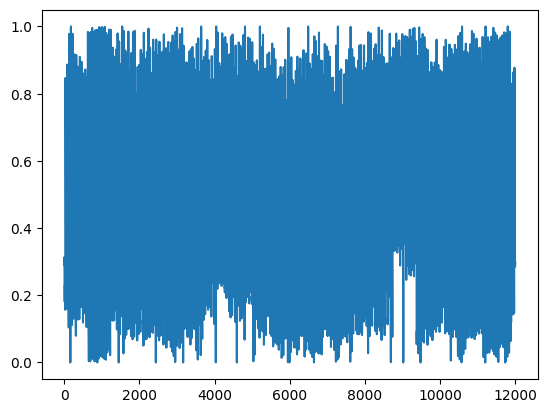

In [37]:
target_flatten = target.transpose(0,2,1).reshape(-1,2)
plt.plot(target_flatten[:12000,0])

In [40]:
train_x.size(0)

TypeError: 'int' object is not callable

In [50]:

from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split

# 正しい順番で受け取る
train_x, val_x, train_y, val_y = train_test_split(
    target, target_sbp, test_size=0.2, random_state=42
)

print(train_x.shape, train_y.shape, val_x.shape, val_y.shape)

train_dataset = torch.utils.data.TensorDataset(
    torch.tensor(train_x).float(),
    torch.tensor(train_y).float()
)
val_dataset = torch.utils.data.TensorDataset(
    torch.tensor(val_x).float(),
    torch.tensor(val_y).float()
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)




(320, 1, 1250) (320,) (80, 1, 1250) (80,)


In [55]:
from se_resnet1d import resnet18mini
import tqdm
from tqdm import trange
model = resnet18mini(num_classes=1,in_channels=1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 300
for epoch in trange(num_epochs):
    train_loss = 0.0
    model.train()
    for batch in train_loader:
        train_x, train_y = batch
        train_x = train_x.to(device)
        train_y = train_y.to(device)
        # print(train_x.shape, train_y.shape)
        out = model(train_x)
        # print(out.shape)
        loss = criterion(out, train_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # print(loss.item())
        
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device).float().unsqueeze(1)
            outputs = model(x_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item() * x_val.size(0)
    
    val_loss /= len(val_loader.dataset)
    
    print(f"Epoch [{epoch+1}/{num_epochs}]  Train Loss: {train_loss:.4f}  Val Loss: {val_loss:.4f}")
    


  0%|          | 0/300 [00:00<?, ?it/s]

  1%|          | 3/300 [00:00<00:36,  8.18it/s]

Epoch [1/300]  Train Loss: 0.0000  Val Loss: 17293.2148
Epoch [2/300]  Train Loss: 0.0000  Val Loss: 17032.5898
Epoch [3/300]  Train Loss: 0.0000  Val Loss: 16722.7295


  2%|▏         | 5/300 [00:00<00:30,  9.58it/s]

Epoch [4/300]  Train Loss: 0.0000  Val Loss: 16475.0818
Epoch [5/300]  Train Loss: 0.0000  Val Loss: 16034.6473
Epoch [6/300]  Train Loss: 0.0000  Val Loss: 15666.6500


  3%|▎         | 9/300 [00:00<00:26, 11.18it/s]

Epoch [7/300]  Train Loss: 0.0000  Val Loss: 15310.9445
Epoch [8/300]  Train Loss: 0.0000  Val Loss: 15009.7367
Epoch [9/300]  Train Loss: 0.0000  Val Loss: 14654.8590


  4%|▎         | 11/300 [00:01<00:25, 11.52it/s]

Epoch [10/300]  Train Loss: 0.0000  Val Loss: 14365.3250
Epoch [11/300]  Train Loss: 0.0000  Val Loss: 13976.2152
Epoch [12/300]  Train Loss: 0.0000  Val Loss: 13558.3824


  5%|▌         | 15/300 [00:01<00:22, 12.40it/s]

Epoch [13/300]  Train Loss: 0.0000  Val Loss: 13183.2754
Epoch [14/300]  Train Loss: 0.0000  Val Loss: 12812.2141
Epoch [15/300]  Train Loss: 0.0000  Val Loss: 12389.9363


  6%|▌         | 17/300 [00:01<00:22, 12.63it/s]

Epoch [16/300]  Train Loss: 0.0000  Val Loss: 12003.3520
Epoch [17/300]  Train Loss: 0.0000  Val Loss: 11612.5463
Epoch [18/300]  Train Loss: 0.0000  Val Loss: 11182.7828


  7%|▋         | 21/300 [00:01<00:21, 12.94it/s]

Epoch [19/300]  Train Loss: 0.0000  Val Loss: 10785.2687
Epoch [20/300]  Train Loss: 0.0000  Val Loss: 10278.0688
Epoch [21/300]  Train Loss: 0.0000  Val Loss: 9866.6187


  8%|▊         | 23/300 [00:01<00:21, 12.70it/s]

Epoch [22/300]  Train Loss: 0.0000  Val Loss: 9330.5027
Epoch [23/300]  Train Loss: 0.0000  Val Loss: 8926.3479
Epoch [24/300]  Train Loss: 0.0000  Val Loss: 8518.5688


  9%|▉         | 27/300 [00:02<00:21, 12.72it/s]

Epoch [25/300]  Train Loss: 0.0000  Val Loss: 8154.7967
Epoch [26/300]  Train Loss: 0.0000  Val Loss: 7631.7838
Epoch [27/300]  Train Loss: 0.0000  Val Loss: 7248.6860


 10%|▉         | 29/300 [00:02<00:20, 12.95it/s]

Epoch [28/300]  Train Loss: 0.0000  Val Loss: 6799.8543
Epoch [29/300]  Train Loss: 0.0000  Val Loss: 6406.0934
Epoch [30/300]  Train Loss: 0.0000  Val Loss: 5939.2298


 11%|█         | 33/300 [00:02<00:20, 13.12it/s]

Epoch [31/300]  Train Loss: 0.0000  Val Loss: 5634.2047
Epoch [32/300]  Train Loss: 0.0000  Val Loss: 5225.1209
Epoch [33/300]  Train Loss: 0.0000  Val Loss: 4943.5955


 12%|█▏        | 35/300 [00:02<00:20, 13.08it/s]

Epoch [34/300]  Train Loss: 0.0000  Val Loss: 4545.6910
Epoch [35/300]  Train Loss: 0.0000  Val Loss: 4211.7339
Epoch [36/300]  Train Loss: 0.0000  Val Loss: 3881.0645


 13%|█▎        | 39/300 [00:03<00:20, 12.97it/s]

Epoch [37/300]  Train Loss: 0.0000  Val Loss: 3666.0909
Epoch [38/300]  Train Loss: 0.0000  Val Loss: 3347.6184
Epoch [39/300]  Train Loss: 0.0000  Val Loss: 3067.9257


 14%|█▎        | 41/300 [00:03<00:20, 12.92it/s]

Epoch [40/300]  Train Loss: 0.0000  Val Loss: 2767.4988
Epoch [41/300]  Train Loss: 0.0000  Val Loss: 2564.8816
Epoch [42/300]  Train Loss: 0.0000  Val Loss: 2336.1303


 15%|█▌        | 45/300 [00:03<00:19, 12.81it/s]

Epoch [43/300]  Train Loss: 0.0000  Val Loss: 2170.1692
Epoch [44/300]  Train Loss: 0.0000  Val Loss: 1965.6330
Epoch [45/300]  Train Loss: 0.0000  Val Loss: 1781.8534


 16%|█▌        | 47/300 [00:03<00:19, 12.89it/s]

Epoch [46/300]  Train Loss: 0.0000  Val Loss: 1563.0792
Epoch [47/300]  Train Loss: 0.0000  Val Loss: 1444.5228
Epoch [48/300]  Train Loss: 0.0000  Val Loss: 1325.5106


 17%|█▋        | 51/300 [00:04<00:19, 12.93it/s]

Epoch [49/300]  Train Loss: 0.0000  Val Loss: 1116.6092
Epoch [50/300]  Train Loss: 0.0000  Val Loss: 1107.9643
Epoch [51/300]  Train Loss: 0.0000  Val Loss: 917.8446


 18%|█▊        | 53/300 [00:04<00:19, 12.75it/s]

Epoch [52/300]  Train Loss: 0.0000  Val Loss: 907.2505
Epoch [53/300]  Train Loss: 0.0000  Val Loss: 786.6386
Epoch [54/300]  Train Loss: 0.0000  Val Loss: 755.9888


 19%|█▉        | 57/300 [00:04<00:18, 12.91it/s]

Epoch [55/300]  Train Loss: 0.0000  Val Loss: 663.7738
Epoch [56/300]  Train Loss: 0.0000  Val Loss: 572.2742
Epoch [57/300]  Train Loss: 0.0000  Val Loss: 554.9461


 20%|█▉        | 59/300 [00:04<00:18, 12.96it/s]

Epoch [58/300]  Train Loss: 0.0000  Val Loss: 540.6739
Epoch [59/300]  Train Loss: 0.0000  Val Loss: 440.5760
Epoch [60/300]  Train Loss: 0.0000  Val Loss: 541.0542


 21%|██        | 63/300 [00:05<00:18, 13.04it/s]

Epoch [61/300]  Train Loss: 0.0000  Val Loss: 323.8430
Epoch [62/300]  Train Loss: 0.0000  Val Loss: 368.6901
Epoch [63/300]  Train Loss: 0.0000  Val Loss: 385.3450


 22%|██▏       | 65/300 [00:05<00:17, 13.16it/s]

Epoch [64/300]  Train Loss: 0.0000  Val Loss: 313.2933
Epoch [65/300]  Train Loss: 0.0000  Val Loss: 356.2257
Epoch [66/300]  Train Loss: 0.0000  Val Loss: 223.3945


 23%|██▎       | 69/300 [00:05<00:17, 13.06it/s]

Epoch [67/300]  Train Loss: 0.0000  Val Loss: 331.9784
Epoch [68/300]  Train Loss: 0.0000  Val Loss: 266.5729
Epoch [69/300]  Train Loss: 0.0000  Val Loss: 292.2936


 24%|██▎       | 71/300 [00:05<00:17, 13.01it/s]

Epoch [70/300]  Train Loss: 0.0000  Val Loss: 296.8542
Epoch [71/300]  Train Loss: 0.0000  Val Loss: 249.0191
Epoch [72/300]  Train Loss: 0.0000  Val Loss: 296.0295


 25%|██▌       | 75/300 [00:06<00:17, 12.74it/s]

Epoch [73/300]  Train Loss: 0.0000  Val Loss: 239.6013
Epoch [74/300]  Train Loss: 0.0000  Val Loss: 260.5018
Epoch [75/300]  Train Loss: 0.0000  Val Loss: 286.5412


 26%|██▌       | 77/300 [00:06<00:17, 12.83it/s]

Epoch [76/300]  Train Loss: 0.0000  Val Loss: 252.1394
Epoch [77/300]  Train Loss: 0.0000  Val Loss: 259.9126
Epoch [78/300]  Train Loss: 0.0000  Val Loss: 295.8252


 27%|██▋       | 81/300 [00:06<00:16, 12.99it/s]

Epoch [79/300]  Train Loss: 0.0000  Val Loss: 255.0847
Epoch [80/300]  Train Loss: 0.0000  Val Loss: 251.7240
Epoch [81/300]  Train Loss: 0.0000  Val Loss: 274.2059


 28%|██▊       | 83/300 [00:06<00:16, 13.14it/s]

Epoch [82/300]  Train Loss: 0.0000  Val Loss: 247.8954
Epoch [83/300]  Train Loss: 0.0000  Val Loss: 217.6878
Epoch [84/300]  Train Loss: 0.0000  Val Loss: 250.6519


 29%|██▉       | 87/300 [00:06<00:16, 13.22it/s]

Epoch [85/300]  Train Loss: 0.0000  Val Loss: 301.5988
Epoch [86/300]  Train Loss: 0.0000  Val Loss: 272.9105
Epoch [87/300]  Train Loss: 0.0000  Val Loss: 216.0357


 30%|██▉       | 89/300 [00:07<00:16, 13.15it/s]

Epoch [88/300]  Train Loss: 0.0000  Val Loss: 221.2998
Epoch [89/300]  Train Loss: 0.0000  Val Loss: 255.2975
Epoch [90/300]  Train Loss: 0.0000  Val Loss: 251.7388


 31%|███       | 93/300 [00:07<00:15, 13.10it/s]

Epoch [91/300]  Train Loss: 0.0000  Val Loss: 204.8102
Epoch [92/300]  Train Loss: 0.0000  Val Loss: 251.8607
Epoch [93/300]  Train Loss: 0.0000  Val Loss: 240.9324


 32%|███▏      | 95/300 [00:07<00:15, 13.30it/s]

Epoch [94/300]  Train Loss: 0.0000  Val Loss: 206.6789
Epoch [95/300]  Train Loss: 0.0000  Val Loss: 249.8574
Epoch [96/300]  Train Loss: 0.0000  Val Loss: 289.9505


 33%|███▎      | 99/300 [00:07<00:15, 12.87it/s]

Epoch [97/300]  Train Loss: 0.0000  Val Loss: 232.5554
Epoch [98/300]  Train Loss: 0.0000  Val Loss: 237.1077
Epoch [99/300]  Train Loss: 0.0000  Val Loss: 243.7656


 34%|███▎      | 101/300 [00:07<00:15, 12.98it/s]

Epoch [100/300]  Train Loss: 0.0000  Val Loss: 224.8325
Epoch [101/300]  Train Loss: 0.0000  Val Loss: 226.4501
Epoch [102/300]  Train Loss: 0.0000  Val Loss: 252.1823


 35%|███▌      | 105/300 [00:08<00:14, 13.01it/s]

Epoch [103/300]  Train Loss: 0.0000  Val Loss: 270.5252
Epoch [104/300]  Train Loss: 0.0000  Val Loss: 274.1916
Epoch [105/300]  Train Loss: 0.0000  Val Loss: 267.4353


 36%|███▌      | 107/300 [00:08<00:14, 13.11it/s]

Epoch [106/300]  Train Loss: 0.0000  Val Loss: 235.9963
Epoch [107/300]  Train Loss: 0.0000  Val Loss: 244.9854
Epoch [108/300]  Train Loss: 0.0000  Val Loss: 246.6141


 37%|███▋      | 111/300 [00:08<00:14, 13.37it/s]

Epoch [109/300]  Train Loss: 0.0000  Val Loss: 241.0777
Epoch [110/300]  Train Loss: 0.0000  Val Loss: 243.0843
Epoch [111/300]  Train Loss: 0.0000  Val Loss: 271.4182
Epoch [112/300]  Train Loss: 0.0000  Val Loss: 273.3861


 38%|███▊      | 115/300 [00:09<00:13, 13.42it/s]

Epoch [113/300]  Train Loss: 0.0000  Val Loss: 236.7378
Epoch [114/300]  Train Loss: 0.0000  Val Loss: 240.9701
Epoch [115/300]  Train Loss: 0.0000  Val Loss: 276.5995


 39%|███▉      | 117/300 [00:09<00:13, 13.45it/s]

Epoch [116/300]  Train Loss: 0.0000  Val Loss: 280.8232
Epoch [117/300]  Train Loss: 0.0000  Val Loss: 273.3044
Epoch [118/300]  Train Loss: 0.0000  Val Loss: 225.1620


 40%|████      | 121/300 [00:09<00:13, 13.25it/s]

Epoch [119/300]  Train Loss: 0.0000  Val Loss: 223.0434
Epoch [120/300]  Train Loss: 0.0000  Val Loss: 205.1284
Epoch [121/300]  Train Loss: 0.0000  Val Loss: 225.0070


 41%|████      | 123/300 [00:09<00:13, 13.04it/s]

Epoch [122/300]  Train Loss: 0.0000  Val Loss: 248.8131
Epoch [123/300]  Train Loss: 0.0000  Val Loss: 238.5990
Epoch [124/300]  Train Loss: 0.0000  Val Loss: 240.8784


 42%|████▏     | 127/300 [00:09<00:13, 12.98it/s]

Epoch [125/300]  Train Loss: 0.0000  Val Loss: 268.5057
Epoch [126/300]  Train Loss: 0.0000  Val Loss: 255.5049
Epoch [127/300]  Train Loss: 0.0000  Val Loss: 240.4176


 43%|████▎     | 129/300 [00:10<00:13, 13.03it/s]

Epoch [128/300]  Train Loss: 0.0000  Val Loss: 245.8120
Epoch [129/300]  Train Loss: 0.0000  Val Loss: 244.3174
Epoch [130/300]  Train Loss: 0.0000  Val Loss: 240.7946


 44%|████▍     | 133/300 [00:10<00:12, 13.00it/s]

Epoch [131/300]  Train Loss: 0.0000  Val Loss: 228.3512
Epoch [132/300]  Train Loss: 0.0000  Val Loss: 245.3239
Epoch [133/300]  Train Loss: 0.0000  Val Loss: 220.4310


 45%|████▌     | 135/300 [00:10<00:12, 13.06it/s]

Epoch [134/300]  Train Loss: 0.0000  Val Loss: 224.5054
Epoch [135/300]  Train Loss: 0.0000  Val Loss: 236.0182
Epoch [136/300]  Train Loss: 0.0000  Val Loss: 248.6561


 46%|████▋     | 139/300 [00:10<00:12, 13.02it/s]

Epoch [137/300]  Train Loss: 0.0000  Val Loss: 255.0325
Epoch [138/300]  Train Loss: 0.0000  Val Loss: 255.8076
Epoch [139/300]  Train Loss: 0.0000  Val Loss: 212.7586


 47%|████▋     | 141/300 [00:11<00:12, 12.96it/s]

Epoch [140/300]  Train Loss: 0.0000  Val Loss: 223.0811
Epoch [141/300]  Train Loss: 0.0000  Val Loss: 257.4406
Epoch [142/300]  Train Loss: 0.0000  Val Loss: 270.2626


 48%|████▊     | 145/300 [00:11<00:11, 13.00it/s]

Epoch [143/300]  Train Loss: 0.0000  Val Loss: 261.9843
Epoch [144/300]  Train Loss: 0.0000  Val Loss: 197.3659
Epoch [145/300]  Train Loss: 0.0000  Val Loss: 178.4619


 49%|████▉     | 147/300 [00:11<00:12, 12.70it/s]

Epoch [146/300]  Train Loss: 0.0000  Val Loss: 238.4314
Epoch [147/300]  Train Loss: 0.0000  Val Loss: 278.3386
Epoch [148/300]  Train Loss: 0.0000  Val Loss: 251.3665


 50%|█████     | 151/300 [00:11<00:11, 12.81it/s]

Epoch [149/300]  Train Loss: 0.0000  Val Loss: 216.1126
Epoch [150/300]  Train Loss: 0.0000  Val Loss: 240.6007
Epoch [151/300]  Train Loss: 0.0000  Val Loss: 249.1901


 51%|█████     | 153/300 [00:11<00:11, 12.69it/s]

Epoch [152/300]  Train Loss: 0.0000  Val Loss: 241.4620
Epoch [153/300]  Train Loss: 0.0000  Val Loss: 241.7685
Epoch [154/300]  Train Loss: 0.0000  Val Loss: 238.4308


 52%|█████▏    | 157/300 [00:12<00:11, 12.70it/s]

Epoch [155/300]  Train Loss: 0.0000  Val Loss: 225.7263
Epoch [156/300]  Train Loss: 0.0000  Val Loss: 221.6735
Epoch [157/300]  Train Loss: 0.0000  Val Loss: 224.6187


 53%|█████▎    | 159/300 [00:12<00:10, 12.93it/s]

Epoch [158/300]  Train Loss: 0.0000  Val Loss: 212.3695
Epoch [159/300]  Train Loss: 0.0000  Val Loss: 221.4609
Epoch [160/300]  Train Loss: 0.0000  Val Loss: 245.1042


 54%|█████▎    | 161/300 [00:12<00:10, 12.65it/s]

Epoch [161/300]  Train Loss: 0.0000  Val Loss: 249.2812
Epoch [162/300]  Train Loss: 0.0000  Val Loss: 235.2376
Epoch [163/300]  Train Loss: 0.0000  Val Loss: 225.0214


 55%|█████▌    | 165/300 [00:12<00:11, 11.75it/s]

Epoch [164/300]  Train Loss: 0.0000  Val Loss: 249.3519
Epoch [165/300]  Train Loss: 0.0000  Val Loss: 240.8043
Epoch [166/300]  Train Loss: 0.0000  Val Loss: 227.7004


 56%|█████▋    | 169/300 [00:13<00:10, 12.51it/s]

Epoch [167/300]  Train Loss: 0.0000  Val Loss: 220.8799
Epoch [168/300]  Train Loss: 0.0000  Val Loss: 223.7527
Epoch [169/300]  Train Loss: 0.0000  Val Loss: 240.8570


 57%|█████▋    | 171/300 [00:13<00:10, 12.39it/s]

Epoch [170/300]  Train Loss: 0.0000  Val Loss: 240.7352
Epoch [171/300]  Train Loss: 0.0000  Val Loss: 247.0064
Epoch [172/300]  Train Loss: 0.0000  Val Loss: 265.0347


 58%|█████▊    | 175/300 [00:13<00:09, 12.68it/s]

Epoch [173/300]  Train Loss: 0.0000  Val Loss: 260.5431
Epoch [174/300]  Train Loss: 0.0000  Val Loss: 245.2321
Epoch [175/300]  Train Loss: 0.0000  Val Loss: 213.1649


 59%|█████▉    | 177/300 [00:13<00:09, 12.92it/s]

Epoch [176/300]  Train Loss: 0.0000  Val Loss: 202.1585
Epoch [177/300]  Train Loss: 0.0000  Val Loss: 208.2383
Epoch [178/300]  Train Loss: 0.0000  Val Loss: 230.5681


 60%|██████    | 181/300 [00:14<00:09, 12.97it/s]

Epoch [179/300]  Train Loss: 0.0000  Val Loss: 286.8076
Epoch [180/300]  Train Loss: 0.0000  Val Loss: 260.4731
Epoch [181/300]  Train Loss: 0.0000  Val Loss: 246.8321


 61%|██████    | 183/300 [00:14<00:09, 12.80it/s]

Epoch [182/300]  Train Loss: 0.0000  Val Loss: 234.5766
Epoch [183/300]  Train Loss: 0.0000  Val Loss: 227.7131
Epoch [184/300]  Train Loss: 0.0000  Val Loss: 231.9359


 62%|██████▏   | 187/300 [00:14<00:08, 13.16it/s]

Epoch [185/300]  Train Loss: 0.0000  Val Loss: 264.0956
Epoch [186/300]  Train Loss: 0.0000  Val Loss: 244.9169
Epoch [187/300]  Train Loss: 0.0000  Val Loss: 219.4051


 63%|██████▎   | 189/300 [00:14<00:08, 13.14it/s]

Epoch [188/300]  Train Loss: 0.0000  Val Loss: 216.9641
Epoch [189/300]  Train Loss: 0.0000  Val Loss: 238.7057
Epoch [190/300]  Train Loss: 0.0000  Val Loss: 248.2669


 64%|██████▍   | 193/300 [00:15<00:08, 13.30it/s]

Epoch [191/300]  Train Loss: 0.0000  Val Loss: 239.5439
Epoch [192/300]  Train Loss: 0.0000  Val Loss: 222.8773
Epoch [193/300]  Train Loss: 0.0000  Val Loss: 221.6259


 65%|██████▌   | 195/300 [00:15<00:08, 12.87it/s]

Epoch [194/300]  Train Loss: 0.0000  Val Loss: 239.4112
Epoch [195/300]  Train Loss: 0.0000  Val Loss: 252.0705
Epoch [196/300]  Train Loss: 0.0000  Val Loss: 266.8013


 66%|██████▋   | 199/300 [00:15<00:07, 12.99it/s]

Epoch [197/300]  Train Loss: 0.0000  Val Loss: 255.6134
Epoch [198/300]  Train Loss: 0.0000  Val Loss: 236.8386
Epoch [199/300]  Train Loss: 0.0000  Val Loss: 241.5818


 67%|██████▋   | 201/300 [00:15<00:07, 13.14it/s]

Epoch [200/300]  Train Loss: 0.0000  Val Loss: 248.7549
Epoch [201/300]  Train Loss: 0.0000  Val Loss: 251.7705
Epoch [202/300]  Train Loss: 0.0000  Val Loss: 244.7394


 68%|██████▊   | 205/300 [00:16<00:07, 13.25it/s]

Epoch [203/300]  Train Loss: 0.0000  Val Loss: 245.1689
Epoch [204/300]  Train Loss: 0.0000  Val Loss: 235.1870
Epoch [205/300]  Train Loss: 0.0000  Val Loss: 233.3540


 69%|██████▉   | 207/300 [00:16<00:06, 13.30it/s]

Epoch [206/300]  Train Loss: 0.0000  Val Loss: 221.4589
Epoch [207/300]  Train Loss: 0.0000  Val Loss: 224.8760
Epoch [208/300]  Train Loss: 0.0000  Val Loss: 225.2689


 70%|███████   | 211/300 [00:16<00:06, 13.25it/s]

Epoch [209/300]  Train Loss: 0.0000  Val Loss: 249.0525
Epoch [210/300]  Train Loss: 0.0000  Val Loss: 272.0024
Epoch [211/300]  Train Loss: 0.0000  Val Loss: 267.6089


 71%|███████   | 213/300 [00:16<00:06, 13.26it/s]

Epoch [212/300]  Train Loss: 0.0000  Val Loss: 268.6679
Epoch [213/300]  Train Loss: 0.0000  Val Loss: 241.5763
Epoch [214/300]  Train Loss: 0.0000  Val Loss: 256.0977


 72%|███████▏  | 217/300 [00:16<00:06, 13.08it/s]

Epoch [215/300]  Train Loss: 0.0000  Val Loss: 244.4070
Epoch [216/300]  Train Loss: 0.0000  Val Loss: 232.2349
Epoch [217/300]  Train Loss: 0.0000  Val Loss: 241.0756


 73%|███████▎  | 219/300 [00:17<00:06, 12.90it/s]

Epoch [218/300]  Train Loss: 0.0000  Val Loss: 241.0280
Epoch [219/300]  Train Loss: 0.0000  Val Loss: 226.0562
Epoch [220/300]  Train Loss: 0.0000  Val Loss: 240.3287


 74%|███████▍  | 223/300 [00:17<00:05, 13.23it/s]

Epoch [221/300]  Train Loss: 0.0000  Val Loss: 262.7691
Epoch [222/300]  Train Loss: 0.0000  Val Loss: 241.7705
Epoch [223/300]  Train Loss: 0.0000  Val Loss: 225.4883


 75%|███████▌  | 225/300 [00:17<00:05, 13.26it/s]

Epoch [224/300]  Train Loss: 0.0000  Val Loss: 218.0849
Epoch [225/300]  Train Loss: 0.0000  Val Loss: 239.9696
Epoch [226/300]  Train Loss: 0.0000  Val Loss: 258.7638


 76%|███████▋  | 229/300 [00:17<00:05, 13.15it/s]

Epoch [227/300]  Train Loss: 0.0000  Val Loss: 238.3324
Epoch [228/300]  Train Loss: 0.0000  Val Loss: 239.8671
Epoch [229/300]  Train Loss: 0.0000  Val Loss: 250.7459


 77%|███████▋  | 231/300 [00:18<00:05, 13.20it/s]

Epoch [230/300]  Train Loss: 0.0000  Val Loss: 255.0730
Epoch [231/300]  Train Loss: 0.0000  Val Loss: 254.3816
Epoch [232/300]  Train Loss: 0.0000  Val Loss: 258.7059


 78%|███████▊  | 235/300 [00:18<00:05, 12.82it/s]

Epoch [233/300]  Train Loss: 0.0000  Val Loss: 260.1125
Epoch [234/300]  Train Loss: 0.0000  Val Loss: 237.6168
Epoch [235/300]  Train Loss: 0.0000  Val Loss: 215.7041


 79%|███████▉  | 237/300 [00:18<00:04, 12.97it/s]

Epoch [236/300]  Train Loss: 0.0000  Val Loss: 205.2848
Epoch [237/300]  Train Loss: 0.0000  Val Loss: 221.8642
Epoch [238/300]  Train Loss: 0.0000  Val Loss: 235.6966


 80%|████████  | 241/300 [00:18<00:04, 12.99it/s]

Epoch [239/300]  Train Loss: 0.0000  Val Loss: 215.7991
Epoch [240/300]  Train Loss: 0.0000  Val Loss: 214.1624
Epoch [241/300]  Train Loss: 0.0000  Val Loss: 234.6200


 81%|████████  | 243/300 [00:18<00:04, 12.76it/s]

Epoch [242/300]  Train Loss: 0.0000  Val Loss: 254.3982
Epoch [243/300]  Train Loss: 0.0000  Val Loss: 240.9851
Epoch [244/300]  Train Loss: 0.0000  Val Loss: 253.7061


 82%|████████▏ | 247/300 [00:19<00:04, 12.78it/s]

Epoch [245/300]  Train Loss: 0.0000  Val Loss: 253.0287
Epoch [246/300]  Train Loss: 0.0000  Val Loss: 220.9697
Epoch [247/300]  Train Loss: 0.0000  Val Loss: 209.0370


 83%|████████▎ | 249/300 [00:19<00:03, 12.94it/s]

Epoch [248/300]  Train Loss: 0.0000  Val Loss: 217.5157
Epoch [249/300]  Train Loss: 0.0000  Val Loss: 230.4039
Epoch [250/300]  Train Loss: 0.0000  Val Loss: 239.3635


 84%|████████▍ | 253/300 [00:19<00:03, 12.89it/s]

Epoch [251/300]  Train Loss: 0.0000  Val Loss: 250.1225
Epoch [252/300]  Train Loss: 0.0000  Val Loss: 249.1807
Epoch [253/300]  Train Loss: 0.0000  Val Loss: 235.1639


 85%|████████▌ | 255/300 [00:19<00:03, 12.99it/s]

Epoch [254/300]  Train Loss: 0.0000  Val Loss: 227.5069
Epoch [255/300]  Train Loss: 0.0000  Val Loss: 224.0679
Epoch [256/300]  Train Loss: 0.0000  Val Loss: 236.4191


 86%|████████▋ | 259/300 [00:20<00:03, 13.14it/s]

Epoch [257/300]  Train Loss: 0.0000  Val Loss: 246.4275
Epoch [258/300]  Train Loss: 0.0000  Val Loss: 254.9439
Epoch [259/300]  Train Loss: 0.0000  Val Loss: 256.0453


 87%|████████▋ | 261/300 [00:20<00:02, 13.17it/s]

Epoch [260/300]  Train Loss: 0.0000  Val Loss: 242.1000
Epoch [261/300]  Train Loss: 0.0000  Val Loss: 229.0971
Epoch [262/300]  Train Loss: 0.0000  Val Loss: 235.2376


 88%|████████▊ | 265/300 [00:20<00:02, 13.03it/s]

Epoch [263/300]  Train Loss: 0.0000  Val Loss: 251.4497
Epoch [264/300]  Train Loss: 0.0000  Val Loss: 274.3921
Epoch [265/300]  Train Loss: 0.0000  Val Loss: 229.7850


 89%|████████▉ | 267/300 [00:20<00:02, 12.94it/s]

Epoch [266/300]  Train Loss: 0.0000  Val Loss: 229.1282
Epoch [267/300]  Train Loss: 0.0000  Val Loss: 244.0952
Epoch [268/300]  Train Loss: 0.0000  Val Loss: 248.3218


 90%|█████████ | 271/300 [00:21<00:02, 12.81it/s]

Epoch [269/300]  Train Loss: 0.0000  Val Loss: 239.1358
Epoch [270/300]  Train Loss: 0.0000  Val Loss: 240.8465
Epoch [271/300]  Train Loss: 0.0000  Val Loss: 242.2498


 91%|█████████ | 273/300 [00:21<00:02, 12.89it/s]

Epoch [272/300]  Train Loss: 0.0000  Val Loss: 259.9592
Epoch [273/300]  Train Loss: 0.0000  Val Loss: 254.2096
Epoch [274/300]  Train Loss: 0.0000  Val Loss: 234.9828


 92%|█████████▏| 277/300 [00:21<00:01, 12.92it/s]

Epoch [275/300]  Train Loss: 0.0000  Val Loss: 242.9266
Epoch [276/300]  Train Loss: 0.0000  Val Loss: 242.0929
Epoch [277/300]  Train Loss: 0.0000  Val Loss: 228.7225


 93%|█████████▎| 279/300 [00:21<00:01, 12.96it/s]

Epoch [278/300]  Train Loss: 0.0000  Val Loss: 243.5643
Epoch [279/300]  Train Loss: 0.0000  Val Loss: 241.5062
Epoch [280/300]  Train Loss: 0.0000  Val Loss: 236.4607


 94%|█████████▍| 283/300 [00:22<00:01, 13.35it/s]

Epoch [281/300]  Train Loss: 0.0000  Val Loss: 249.2823
Epoch [282/300]  Train Loss: 0.0000  Val Loss: 252.4557
Epoch [283/300]  Train Loss: 0.0000  Val Loss: 237.8922


 95%|█████████▌| 285/300 [00:22<00:01, 13.24it/s]

Epoch [284/300]  Train Loss: 0.0000  Val Loss: 230.5800
Epoch [285/300]  Train Loss: 0.0000  Val Loss: 247.1178
Epoch [286/300]  Train Loss: 0.0000  Val Loss: 243.6477


 96%|█████████▋| 289/300 [00:22<00:00, 13.12it/s]

Epoch [287/300]  Train Loss: 0.0000  Val Loss: 247.0057
Epoch [288/300]  Train Loss: 0.0000  Val Loss: 254.1313
Epoch [289/300]  Train Loss: 0.0000  Val Loss: 233.7661


 97%|█████████▋| 291/300 [00:22<00:00, 13.16it/s]

Epoch [290/300]  Train Loss: 0.0000  Val Loss: 235.6926
Epoch [291/300]  Train Loss: 0.0000  Val Loss: 229.8589
Epoch [292/300]  Train Loss: 0.0000  Val Loss: 233.0868


 98%|█████████▊| 295/300 [00:22<00:00, 12.97it/s]

Epoch [293/300]  Train Loss: 0.0000  Val Loss: 244.0745
Epoch [294/300]  Train Loss: 0.0000  Val Loss: 239.8739
Epoch [295/300]  Train Loss: 0.0000  Val Loss: 248.0587


 99%|█████████▉| 297/300 [00:23<00:00, 13.00it/s]

Epoch [296/300]  Train Loss: 0.0000  Val Loss: 240.6418
Epoch [297/300]  Train Loss: 0.0000  Val Loss: 229.2475
Epoch [298/300]  Train Loss: 0.0000  Val Loss: 238.5614


100%|██████████| 300/300 [00:23<00:00, 12.86it/s]

Epoch [299/300]  Train Loss: 0.0000  Val Loss: 260.1208
Epoch [300/300]  Train Loss: 0.0000  Val Loss: 263.1654


# use csv


In [1]:
import pandas as pd
import numpy as np

In [3]:
train_path = "../../data/results/ppg_features_pulsedb_train3_{}.csv"   
test_path = "../../data/results/ppg_features_pulsedb_test5_{}.csv"   
all_df = None

for i in range(11):
    df = pd.read_csv(test_path.format(i),index_col=0)
    if i==0:
        all_df = df
    else:
        all_df = pd.concat([all_df,df],axis=0)
y = np.load("../../data/processed/BP_npy/PulseDB/test_sbp.npy")
y2 = np.load("../../data/processed/BP_npy/PulseDB/test_dbp.npy")
print(y.shape)
print(y2.shape)
# concat with df["signal_index"] and y index (y is bigger)
all_df = all_df.reset_index(drop=True)
all_df["sbp"] = y[all_df["signal_index"].values]
all_df["dbp"] = y2[all_df["signal_index"].values]
subject = np.load("../../data/processed/BP_npy/PulseDB/test_subjects.npy")
all_df["subject"] = subject[all_df["signal_index"].values]
all_df.to_csv("../../data/results/ppg_features_pulsedb_test5_all.csv")
# for i in range(90):
#     df = pd.read_csv(train_path.format(i),index_col=0)
#     if i==0:
#         all_df = df
#     else:
#         all_df = pd.concat([all_df,df],axis=0)
# y = np.load("../../data/processed/BP_npy/PulseDB/train_sbp.npy")
# y2 = np.load("../../data/processed/BP_npy/PulseDB/train_dbp.npy")
# print(y.shape)
# print(y2.shape)
# # concat with df["signal_index"] and y index (y is bigger)
# all_df = all_df.reset_index(drop=True)
# all_df["sbp"] = y[all_df["signal_index"].values]
# all_df["dbp"] = y2[all_df["signal_index"].values]
# subject = np.load("../../data/processed/BP_npy/PulseDB/train_subjects.npy")
# all_df["subject"] = subject[all_df["signal_index"].values]
# all_df.to_csv("../../data/results/ppg_features_pulsedb_train3_all.csv")

(111600,)
(111600,)


In [4]:
all_df.shape,all_df.head()

((846791, 99),
          Tc        Ts        Td  Tsteepest  Steepest  TNegSteepest  \
 0  0.805818  0.152727  0.653091   0.093091  0.017257      0.193455   
 1  0.827636  0.130909  0.696727   0.081455  0.017853      0.161455   
 2  0.825333  0.141333  0.684000   0.075333  0.017917      0.185333   
 3  0.764667  0.146000  0.618667   0.086000  0.021121      0.182000   
 4  0.831333  0.142667  0.688667   0.073333  0.017336      0.186000   
 
    NegSteepest  TdiaRise   DiaRise  SteepDiaRise  ...  T_peak_b_norm  \
 0    -0.002909  0.235636  0.427628     -0.001949  ...       0.032485   
 1    -0.005248  0.222545  0.418363     -0.001128  ...       0.028278   
 2    -0.001618  0.213333  0.440137     -0.001977  ...       0.044325   
 3    -0.002257  0.223333  0.532734     -0.000972  ...       0.046586   
 4    -0.002146  0.210000  0.412856     -0.002240  ...       0.027010   
 
    T_peak_c_norm  T_peak_d_norm  T_peak_e_norm        AI        bd      bcda  \
 0       0.018421       0.067083    

In [16]:
all_df.columns.tolist()

['Tc',
 'Ts',
 'Td',
 'Tsteepest',
 'Steepest',
 'TNegSteepest',
 'NegSteepest',
 'TdiaRise',
 'DiaRise',
 'SteepDiaRise',
 'TSystoDiaRise',
 'TdiaToEnd',
 'Ratio',
 'Ts_norm',
 'Td_norm',
 'Tsteepest_norm',
 'TNegSteepest_norm',
 'TdiaRise_norm',
 'TSystoDiaRise_norm',
 'TdiaToEnd_norm',
 'SW25',
 'SW25_norm',
 'DW25',
 'DW25_norm',
 'SWaddDW25',
 'SWaddDW25_norm',
 'DWdivSW25',
 'SW50',
 'SW50_norm',
 'DW50',
 'DW50_norm',
 'SWaddDW50',
 'SWaddDW50_norm',
 'DWdivSW50',
 'SW75',
 'SW75_norm',
 'DW75',
 'DW75_norm',
 'SWaddDW75',
 'SWaddDW75_norm',
 'DWdivSW75',
 'S1',
 'S2',
 'S3',
 'S4',
 'AUCsys',
 'AUCdia',
 'S1_norm',
 'S2_norm',
 'S3_norm',
 'S4_norm',
 'AUCsys_norm',
 'AUCdia_norm',
 'SQI_skew',
 'SQI_kurtosis',
 'apg_a',
 'apg_b',
 'apg_c',
 'apg_d',
 'apg_e',
 'ppg_a',
 'ppg_b',
 'ppg_c',
 'ppg_d',
 'ppg_e',
 'ratio_apg_b',
 'ratio_apg_c',
 'ratio_apg_d',
 'ratio_apg_e',
 'ratio_ppg_b',
 'ratio_ppg_c',
 'ratio_ppg_d',
 'ratio_ppg_e',
 'T_a',
 'T_b',
 'T_c',
 'T_d',
 'T_e',
 'T

In [11]:
len(all_df)

103364

In [15]:
nan_a = all_df['apg_a'].isna().sum()
nan_b = all_df['apg_b'].isna().sum()
nan_c = all_df['apg_c'].isna().sum()
nan_d = all_df['apg_d'].isna().sum()
nan_e = all_df['apg_e'].isna().sum()
nan_a,nan_b,nan_c,nan_d,nan_e

(0, 14, 2883, 2883, 2884)

In [17]:
# y = np.load("../../data/processed/BP_npy/PulseDB/train_sbp.npy")
# y2 = np.load("../../data/processed/BP_npy/PulseDB/train_dbp.npy")
y = np.load("../../data/processed/BP_npy/PulseDB/test_sbp.npy")
y2 = np.load("../../data/processed/BP_npy/PulseDB/test_dbp.npy")
print(y.shape)
print(y2.shape)
# concat with df["signal_index"] and y index (y is bigger)
all_df = all_df.reset_index(drop=True)
all_df["sbp"] = y[all_df["signal_index"].values]
all_df["dbp"] = y2[all_df["signal_index"].values]

(111600,)
(111600,)


In [18]:
subject = np.load("../../data/processed/BP_npy/PulseDB/test_subjects.npy")
# subject = np.load("../../data/processed/BP_npy/PulseDB/train_subjects.npy")
num,count = np.unique(subject,return_counts=True)

In [32]:
print(list(num[np.where(count>360)]))

[188, 652, 735, 773, 1501, 1840, 1855, 2343, 2636, 2906, 4331, 5382]


(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0., 279.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.]),
 array([399.5 , 399.51, 399.52, 399.53, 399.54, 399.55, 399.56, 399.57,
        399.58, 399.59, 399.6 , 399.61, 399.62, 399.63, 399.64, 399.65,
        399.66, 399.67, 399.68, 399.69, 399.7 , 399.71, 399.72, 399.73,
        399.74, 399.75, 399.76, 399.77, 399.78, 399.79, 399.8 , 399.81,
        399.82, 399.83, 399.84

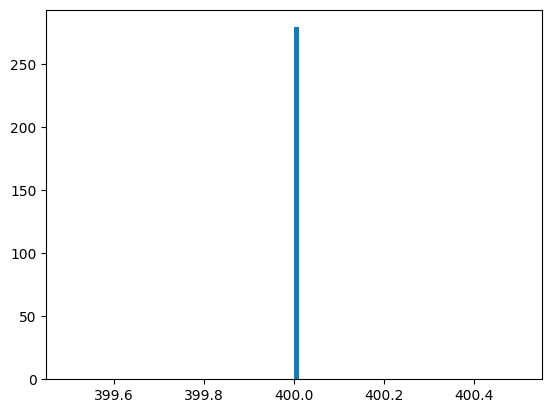

In [8]:
import matplotlib.pyplot as plt
plt.hist(count,bins=100)

In [19]:
all_df["subject"] = subject[all_df["signal_index"].values]

In [10]:
# collect subject and count 
subject_counts = all_df["subject"].value_counts()
print(subject_counts[:10]   )

subject
4426     400
5035     400
60226    399
8167     399
68703    399
4795     399
86068    399
66152    398
68       398
50634    398
Name: count, dtype: int64


(array([ 1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         2.,  0.,  2.,  2.,  2.,  2.,  1.,  0.,  0.,  0.,  1.,  2.,  0.,
         1.,  1.,  0.,  1.,  0.,  0.,  1.,  2.,  1.,  2.,  1.,  0.,  1.,
         1.,  1.,  0.,  2.,  1.,  5.,  1.,  0.,  0.,  1.,  2.,  2.,  3.,
         4.,  1.,  2.,  2.,  4.,  0.,  1.,  1.,  3.,  1.,  3.,  6.,  4.,
         2.,  3.,  4.,  5.,  3.,  5.,  5.,  2.,  5.,  6.,  6.,  4.,  9.,
         9., 13., 18.,  8., 17., 17., 14., 25., 13.]),
 array([ 18.  ,  21.82,  25.64,  29.46,  33.28,  37.1 ,  40.92,  44.74,
         48.56,  52.38,  56.2 ,  60.02,  63.84,  67.66,  71.48,  75.3 ,
         79.12,  82.94,  86.76,  90.58,  94.4 ,  98.22, 102.04, 105.86,
        109.68, 113.5 , 117.32, 121.14, 124.96, 128.78, 132.6 , 136.42,
        140.24, 144.06, 147.88, 151.7 , 155.52, 159.34, 163.16, 166.98,
        170.8 , 174.62, 178.44, 182.26, 186.08, 189.9 , 193.72, 197.54,
  

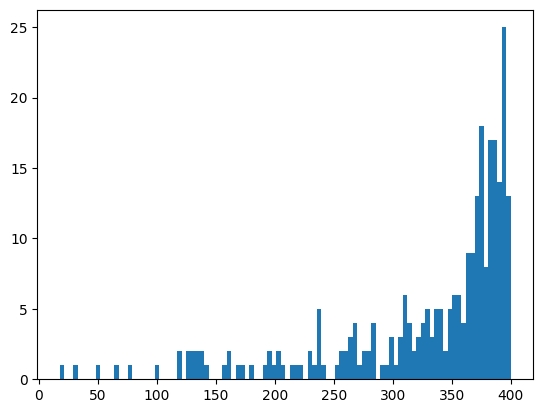

In [11]:
plt.hist(subject_counts,bins=100)

In [12]:
# sum of counts where count >300
sub = subject_counts[subject_counts>180]
sub.sum(),sub.sum() / len(all_df)

(87507, 0.9691878301897241)

In [13]:
# get the list of left side (subject)
subject_counts.index[subject_counts>180]

Index([ 4426,  5035, 60226,  8167, 68703,  4795, 86068, 66152,    68, 50634,
       ...
       78892, 12174,  1492,  1052,   317,  3246,  5049,  1523,  4434,   266],
      dtype='int32', name='subject', length=252)

In [14]:
df_used = all_df[all_df["subject"].isin(subject_counts.index[subject_counts>180])]
df_used.shape

(87507, 102)

In [20]:
# save
# df_used.to_csv("../../data/results/ppg_features_pulsedb_test_min180.csv")
all_df.to_csv("../../data/results/ppg_features_pulsedb_test3_all.csv")

# lightgbm

## mapping


In [1]:
import os
import time
from multiprocessing import Pool

import numpy as np
from numpy import linalg as LA

from tqdm.contrib.concurrent import process_map

euclid_threshold = 2.5  # Euclidean Distance threshold
cross_corr_threshold = 0.9  # Cross-Correlation threshold
sbp_threshold = 8  # Systolic Blood Pressure threshold
def align(ref, can, ref_sign, can_sign):
    """
    Function for aligning two signals.

    Args:
        ref (numpy_arr): normalized reference signal
        can (numpy_arr): normalized candidate signal
        ref_sign (numpy_arr): reference signal
        can_sign (numpy_arr): candidate signal

    Returns:
        _type_: 2 numpy arrays
    """
    corr = np.correlate(ref, can, mode="same")
    delay = np.argmax(corr) - (len(ref) // 2)
    if delay == 0:
        return ref_sign, can_sign
    elif delay > 0:
        return ref_sign[delay:], can_sign[:-delay]
    else:
        return ref_sign[:delay], can_sign[abs(delay) :]


def check(ppg,sbp,i,dst_path="../../data/results/mapping"):
    """
    For each record index, It finds signals which are above the cross-correlation threshold and systolic blood pressure threshold

    Args:
        i (int): Record index
    """
    count = 0
    ans = []
    temp = np.zeros((len(ppg)))
    for j in range(len(ppg)):
        # abp_arr = abp[i][j]
        sbp_val = sbp[j]
        for k in range(len(ppg)):
            # corr = np.correlate(ppg[j], ppg[k]) / ppg_sqrt[j] / ppg_sqrt[k]
            # corr = np.corrcoef(ppg[j], ppg[k])[0,1]
              # Obtain the correlation value between the normalized signals
            # print(corr,i,j,k)
            corr=1
            if corr >= cross_corr_threshold:
                ppg_1, ppg_2 = align(
                    ppg[j], ppg[k], ppg[j], ppg[k]
                )
                dist = np.linalg.norm(ppg_1 - ppg_2) / max(
                    np.max(ppg_1), np.max(ppg_2)
                )  # Calculate the Euclidean Distance
                # print(corr,dist,i,j,k)
                if dist < euclid_threshold and (
                    # abs(np.mean(abp_arr) - np.mean(abp[i][k])) > sbp_threshold
                    abs(sbp_val - sbp[k]) > sbp_threshold
                ):
                    count += 1
                    temp[k] = 1
                    ans.append([j, k, corr, dist,sbp_val,sbp[k]])
    print(f"Record {i} has {count} collisions, {int(np.sum(temp))}/{len(ppg)}, {int(int(np.sum(temp))/len(ppg)*1000)/10}%")
    np.save(
        f"{dst_path}/raw/{i}.npy",
        np.asarray([len(ppg), count, np.sum(temp)]),
    )  # Store the total number of collisions present in each record
    np.save(
        f"{dst_path}/val/{i}.npy", np.asarray(ans, dtype=object)
    )  # Stores all the collisions with indices and values

In [2]:
val_1=np.load("../../data/results/mapping/val/1.npy",allow_pickle=True)

In [3]:
val_1

array([[0, 57, 1, 1.966957342631649, 130.70580747487784,
        119.0074328958828],
       [0, 98, 1, 2.183804272781567, 130.70580747487784,
        118.47849855443782],
       [0, 192, 1, 2.347943515226454, 130.70580747487784,
        120.94092073981231],
       ...,
       [356, 245, 1, 1.9189497947469303, 132.60852528798557,
        119.3708689127603],
       [357, 136, 1, 2.4438200958042646, 141.62528153662026,
        122.607622199434],
       [357, 250, 1, 2.490993216796576, 141.62528153662026,
        118.3438991135071]], dtype=object)

In [2]:
import pandas as pd
import numpy as np
import  matplotlib.pyplot as plt
from tqdm import tqdm

In [4]:
user_df = pd.read_csv("../../data/results/ppg_features_pulsedb_train_min180.csv",index_col=0)
# extract signal_index ,subject ,sbp
user_df = user_df[["signal_index","subject","sbp"]]

NameError: name 'pd' is not defined

In [4]:
ppg = np.load("../../data/processed/BP_npy/PulseDB/train_4.npy").squeeze()
ppg.shape

(902160, 1250)

In [36]:
target_ppg.shape

(360, 1250)

In [76]:
import numpy as np
from scipy import signal

def cross_correlation(x, y, normalize=True):
    """
    x, y: 1D numpy arrays (same or different lengths)
    normalize: if True, return normalized cross-correlation (pearson-like) in range [-1,1]
    Returns: lags (int array), ccf (array) where ccf[i] corresponds to lag lags[i]
    """
    x = np.asarray(x)
    y = np.asarray(y)
    assert x.ndim == 1 and y.ndim == 1

    # compute full cross-correlation (lags from -(len(y)-1) to +(len(x)-1))
    c = signal.correlate(x, y, mode='full')   # matches sum_n x[n]*y[n+lag]
    len_x = x.size
    len_y = y.size
    lags = np.arange(-len_y + 1, len_x)

    # if normalize:
    #     # Normalization factor: sqrt( sum x^2 * sum y^2 )
    #     # This is a global normalization (gives pearson-like but not exactly sample-wise unbiased for each lag).
    #     # For sample-wise normalization per lag you may compute local energy windows (more expensive).
    #     denom = np.sqrt(np.sum(x**2) * np.sum(y**2))
    #     if denom == 0:
    #         return lags, c  # avoid divide-by-zero; caller handles
    #     c = c / denom

    return  c
# lag,c = cross_correlation(target_ppg[0], target_ppg[1])
# max(c)

array([[1.        , 0.58701945],
       [0.58701945, 1.        ]])

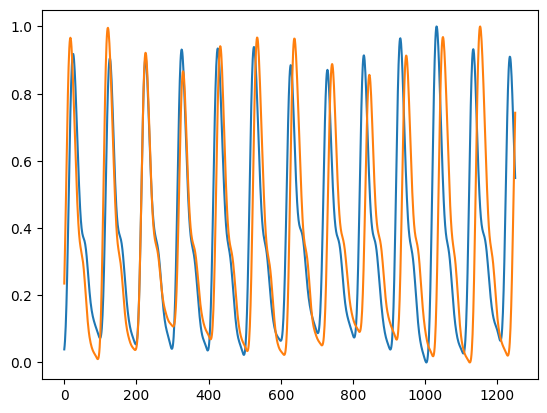

In [51]:
plt.plot(target_ppg[0])
plt.plot(target_ppg[1])
corr = np.corrcoef(target_ppg[0], target_ppg[1])
corr

In [40]:
target_ppg.shape

(360, 1250)

In [39]:
np.correlate(target_ppg[0], target_ppg[1]) 

array([232.40325459])

In [23]:
target_df = user_df[user_df["subject"]==1]
target_df.shape

(360, 3)

In [ ]:
ta

In [72]:
ppg_sqrt = np.sqrt(np.sum(ppg**2,axis=1))

In [22]:
from tqdm import tqdm
for group_id, group_df in tqdm(user_df.groupby("subject")):
    target_ppg =ppg[group_df["signal_index"].values]
    
    # print(group_id,target_ppg.shape)
    check(target_ppg,group_df["sbp"].values,group_id)

  0%|          | 1/2225 [00:12<7:35:56, 12.30s/it]

Record 1 has 2604 collisions, 293/360, 81.3%


  0%|          | 2/2225 [00:22<6:50:26, 11.08s/it]

Record 3 has 778 collisions, 182/342, 53.2%


  0%|          | 3/2225 [00:30<6:01:55,  9.77s/it]

Record 5 has 104 collisions, 74/306, 24.1%


  0%|          | 4/2225 [00:41<6:21:18, 10.30s/it]

Record 12 has 870 collisions, 236/355, 66.4%


  0%|          | 5/2225 [00:52<6:30:47, 10.56s/it]

Record 13 has 422 collisions, 178/349, 51.0%


  0%|          | 6/2225 [01:03<6:37:25, 10.75s/it]

Record 16 has 1850 collisions, 296/352, 84.0%


  0%|          | 6/2225 [01:10<7:15:31, 11.78s/it]


KeyboardInterrupt: 

In [ ]:
process_map(check, [ (group_id, group_df) for group_id, group_df in tqdm(user_df.groupby("subject"))], max_workers=12)

100%|██████████| 2225/2225 [00:00<00:00, 8794.43it/s] 
C:\Users\bsa\AppData\Local\Temp\ipykernel_7044\1899546130.py:1: TqdmWarning: Iterable length 2225 > 1000 but `chunksize` is not set. This may seriously degrade multiprocess performance. Set `chunksize=1` or more.
  process_map(check, [ (group_id, group_df) for group_id, group_df in tqdm(user_df.groupby("subject"))], max_workers=12)


  0%|          | 0/2225 [00:00<?, ?it/s]

In [ ]:
raw_data = np.load("../../data/results/mapping/raw/52.npy")
# total number of windows in the record
# total number of multi-valued mappings/collisions in the record
# number of indices which had atleast one collision. 
raw_data

array([351.,   0.,   0.])

In [ ]:
user_df[user_df["subject"]==1]

In [86]:
results = []
for group_id, group_df in tqdm(user_df.groupby("subject")):
    raw_data = np.load(f"../../data/results/mapping/raw/{group_id}.npy")
    dic = {
        "subject": group_id,
        "total_windows": raw_data[0],
        "total_collisions": raw_data[1],
        "num_indices_with_collisions": raw_data[2],
        "ratio_collisions": raw_data[1]/raw_data[0] if raw_data[0]>0 else 0
    }
    results.append(dic)
    print(dic)
import pandas as pd
df = pd.DataFrame(results)
df.to_csv("../../data/results/mapping_summary.csv",index=False)

  0%|          | 9/2225 [00:00<00:03, 599.90it/s]

{'subject': 1, 'total_windows': 360.0, 'total_collisions': 1782.0, 'num_indices_with_collisions': 309.0, 'ratio_collisions': 4.95}
{'subject': 3, 'total_windows': 342.0, 'total_collisions': 0.0, 'num_indices_with_collisions': 0.0, 'ratio_collisions': 0.0}
{'subject': 5, 'total_windows': 306.0, 'total_collisions': 0.0, 'num_indices_with_collisions': 0.0, 'ratio_collisions': 0.0}
{'subject': 12, 'total_windows': 355.0, 'total_collisions': 0.0, 'num_indices_with_collisions': 0.0, 'ratio_collisions': 0.0}
{'subject': 13, 'total_windows': 349.0, 'total_collisions': 0.0, 'num_indices_with_collisions': 0.0, 'ratio_collisions': 0.0}
{'subject': 16, 'total_windows': 352.0, 'total_collisions': 0.0, 'num_indices_with_collisions': 0.0, 'ratio_collisions': 0.0}
{'subject': 19, 'total_windows': 299.0, 'total_collisions': 0.0, 'num_indices_with_collisions': 0.0, 'ratio_collisions': 0.0}
{'subject': 24, 'total_windows': 276.0, 'total_collisions': 0.0, 'num_indices_with_collisions': 0.0, 'ratio_collisi

EOFError: No data left in file